# Embedding and Visualization of Original vs Paraphrased Responses

This notebook:
1. Loads the dataset `Taywon/alpaca_Llama-3.1-8B-Instruct_tiger_greedy_divergence`
2. Embeds `original_response` and `paraphrased_response` using OpenAI's `text-embedding-3-large` model
3. Saves embeddings to disk
4. Visualizes embeddings using PCA (2D)
5. Plots cosine similarity distribution between pairs


## Import Libraries


In [28]:
import os
import pickle
import numpy as np
from openai import OpenAI
from datasets import load_dataset
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from tqdm import tqdm
import time


## Configuration


In [41]:
# Configuration parameters
DATASET_NAME = "Taywon/alpaca_Llama-3.1-8B-Instruct_tiger_greedy_divergence"
EMBEDDING_MODEL = "text-embedding-3-large"
MAX_SAMPLES = None  # Set to None to process all samples, or specify a number (e.g., 100)
BATCH_SIZE = 50  # Number of texts to embed in each API call
EMBEDDINGS_FILE = "tiger_greedy_embeddings.pkl"  # File to save/load embeddings

# Initialize OpenAI client (assumes OPENAI_API_KEY is set in environment)
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))


## Load Dataset


In [30]:
# Load dataset from HuggingFace
print(f"Loading dataset: {DATASET_NAME}")
dataset = load_dataset(DATASET_NAME)

# Get the train split (adjust if needed)
data = dataset['train']

# Limit samples if specified
if MAX_SAMPLES is not None:
    data = data.select(range(min(MAX_SAMPLES, len(data))))

print(f"Total samples to process: {len(data)}")
print(f"\nDataset columns: {data.column_names}")
print(f"\nFirst example:")
print(data[0])


Loading dataset: Taywon/alpaca_Llama-3.1-8B-Instruct_tiger_greedy_divergence
Total samples to process: 20177

Dataset columns: ['idx', 'divergence_ratio', 'total_tokens', 'divergent_tokens', 'prompt', 'original_response', 'paraphrased_response', 'tokens', 'token_ids', 'divergence_flags', 'divergence_details']

First example:
{'idx': 0, 'divergence_ratio': 0.013157894736842, 'total_tokens': 76, 'divergent_tokens': 1, 'prompt': 'Instruction: Give three tips for staying healthy.', 'original_response': '1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. \n2. Exercise regularly to keep your body active and strong. \n3. Get enough sleep and maintain a consistent sleep schedule.', 'paraphrased_response': "To keep your body thriving, it's essential to fuel it with a well-rounded diet rich in a variety of colorful fruits and leafy greens. Regular physical activity is also crucial, as it helps keep your muscles and cardiovascular system in top shape. Lastly, prioriti

## Extract Responses


In [31]:
# Extract original and paraphrased responses
original_responses = [item['original_response'] for item in data]
paraphrased_responses = [item['paraphrased_response'] for item in data]

print(f"Extracted {len(original_responses)} original responses")
print(f"Extracted {len(paraphrased_responses)} paraphrased responses")
print(f"\nExample original response: {original_responses[0][:200]}...")
print(f"\nExample paraphrased response: {paraphrased_responses[0][:200]}...")


Extracted 20177 original responses
Extracted 20177 paraphrased responses

Example original response: 1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. 
2. Exercise regularly to keep your body active and strong. 
3. Get enough sleep and maintain a consistent sleep schedul...

Example paraphrased response: To keep your body thriving, it's essential to fuel it with a well-rounded diet rich in a variety of colorful fruits and leafy greens. Regular physical activity is also crucial, as it helps keep your m...


In [32]:
# Extract original and paraphrased responses and divergent_tokens
original_responses = [item['original_response'] for item in data]
paraphrased_responses = [item['paraphrased_response'] for item in data]
divergent_tokens = np.array([item['divergent_tokens'] for item in data])

print(f"Extracted {len(original_responses)} original responses")
print(f"Extracted {len(paraphrased_responses)} paraphrased responses")
print(f"Extracted {len(divergent_tokens)} divergent_tokens values")
print(f"\nDivergent tokens statistics:")
print(f"  - Min: {divergent_tokens.min()}")
print(f"  - Max: {divergent_tokens.max()}")
print(f"  - Mean: {divergent_tokens.mean():.2f}")
print(f"  - Median: {np.median(divergent_tokens):.2f}")
print(f"\nExample original response: {original_responses[0][:200]}...")
print(f"\nExample paraphrased response: {paraphrased_responses[0][:200]}...")


Extracted 20177 original responses
Extracted 20177 paraphrased responses
Extracted 20177 divergent_tokens values

Divergent tokens statistics:
  - Min: 0
  - Max: 310
  - Mean: 8.50
  - Median: 2.00

Example original response: 1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. 
2. Exercise regularly to keep your body active and strong. 
3. Get enough sleep and maintain a consistent sleep schedul...

Example paraphrased response: To keep your body thriving, it's essential to fuel it with a well-rounded diet rich in a variety of colorful fruits and leafy greens. Regular physical activity is also crucial, as it helps keep your m...


In [46]:
def get_embeddings_batch(texts, model=EMBEDDING_MODEL, batch_size=BATCH_SIZE):
    """
    Get embeddings for a list of texts using OpenAI API.
    Processes in batches to handle rate limits and large datasets.
    """
    all_embeddings = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding batches"):
        batch = texts[i:i + batch_size]
        
        try:
            response = client.embeddings.create(
                input=batch,
                model=model
            )
            
            batch_embeddings = [item.embedding for item in response.data]
            all_embeddings.extend(batch_embeddings)
            
            # Small delay to avoid rate limits
            time.sleep(0.1)
            
        except Exception as e:
            print(f"Error in batch {i//batch_size}: {e}")
            response = [None] * batch_size
            # Retry with smaller batch or skip
            time.sleep(0.1)
            # Move on to the next batch
            all_embeddings.extend(response)
    
    return np.array(all_embeddings)


## Generate or Load Embeddings


In [47]:
# Check if embeddings already exist
if os.path.exists(EMBEDDINGS_FILE):
    print(f"Loading embeddings from {EMBEDDINGS_FILE}...")
    with open(EMBEDDINGS_FILE, 'rb') as f:
        embeddings_data = pickle.load(f)
        original_embeddings = embeddings_data['original_embeddings']
        paraphrased_embeddings = embeddings_data['paraphrased_embeddings']
    print(f"Loaded embeddings: {original_embeddings.shape}")
else:
    print("Generating embeddings...")
    print("\nEmbedding original responses...")
    original_embeddings = get_embeddings_batch(original_responses)
    
    print("\nEmbedding paraphrased responses...")
    paraphrased_embeddings = get_embeddings_batch(paraphrased_responses)
    
    # Save embeddings
    print(f"\nSaving embeddings to {EMBEDDINGS_FILE}...")
    with open(EMBEDDINGS_FILE, 'wb') as f:
        pickle.dump({
            'original_embeddings': original_embeddings,
            'paraphrased_embeddings': paraphrased_embeddings,
            'model': EMBEDDING_MODEL,
            'dataset': DATASET_NAME,
            'num_samples': len(original_responses)
        }, f)
    print("Embeddings saved successfully!")

print(f"\nOriginal embeddings shape: {original_embeddings.shape}")
print(f"Paraphrased embeddings shape: {paraphrased_embeddings.shape}")


Generating embeddings...

Embedding original responses...


Embedding batches:   1%|          | 4/404 [00:02<04:43,  1.41it/s]

Error in batch 3: Error code: 400 - {'error': {'message': "'$.input' is invalid. Please check the API reference: https://platform.openai.com/docs/api-reference.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Embedding batches:   5%|▍         | 19/404 [00:12<03:46,  1.70it/s]

Error in batch 18: Error code: 400 - {'error': {'message': "'$.input' is invalid. Please check the API reference: https://platform.openai.com/docs/api-reference.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Embedding batches:   6%|▌         | 24/404 [00:16<03:58,  1.59it/s]

Error in batch 23: Error code: 400 - {'error': {'message': "'$.input' is invalid. Please check the API reference: https://platform.openai.com/docs/api-reference.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Embedding batches:  26%|██▌       | 106/404 [01:26<03:27,  1.44it/s]

Error in batch 105: Error code: 400 - {'error': {'message': "'$.input' is invalid. Please check the API reference: https://platform.openai.com/docs/api-reference.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Embedding batches:  30%|███       | 123/404 [01:40<02:49,  1.65it/s]

Error in batch 122: Error code: 400 - {'error': {'message': "'$.input' is invalid. Please check the API reference: https://platform.openai.com/docs/api-reference.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Embedding batches:  38%|███▊      | 153/404 [02:04<03:10,  1.32it/s]

Error in batch 152: Error code: 400 - {'error': {'message': "'$.input' is invalid. Please check the API reference: https://platform.openai.com/docs/api-reference.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Embedding batches:  38%|███▊      | 154/404 [02:04<02:43,  1.53it/s]

Error in batch 153: Error code: 400 - {'error': {'message': "'$.input' is invalid. Please check the API reference: https://platform.openai.com/docs/api-reference.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Embedding batches:  39%|███▊      | 156/404 [02:05<02:36,  1.59it/s]

Error in batch 155: Error code: 400 - {'error': {'message': "'$.input' is invalid. Please check the API reference: https://platform.openai.com/docs/api-reference.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Embedding batches:  49%|████▉     | 198/404 [02:40<02:41,  1.27it/s]

Error in batch 197: Error code: 400 - {'error': {'message': "'$.input' is invalid. Please check the API reference: https://platform.openai.com/docs/api-reference.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Embedding batches:  50%|█████     | 203/404 [02:45<02:55,  1.15it/s]

Error in batch 202: Error code: 400 - {'error': {'message': "'$.input' is invalid. Please check the API reference: https://platform.openai.com/docs/api-reference.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Embedding batches:  78%|███████▊  | 316/404 [04:22<01:04,  1.37it/s]

Error in batch 315: Error code: 400 - {'error': {'message': "'$.input' is invalid. Please check the API reference: https://platform.openai.com/docs/api-reference.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Embedding batches:  81%|████████  | 327/404 [04:32<00:54,  1.42it/s]

Error in batch 326: Error code: 400 - {'error': {'message': "'$.input' is invalid. Please check the API reference: https://platform.openai.com/docs/api-reference.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Embedding batches:  81%|████████▏ | 329/404 [04:33<00:50,  1.48it/s]

Error in batch 328: Error code: 400 - {'error': {'message': "'$.input' is invalid. Please check the API reference: https://platform.openai.com/docs/api-reference.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Embedding batches:  82%|████████▏ | 330/404 [04:34<00:42,  1.74it/s]

Error in batch 329: Error code: 400 - {'error': {'message': "'$.input' is invalid. Please check the API reference: https://platform.openai.com/docs/api-reference.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Embedding batches:  94%|█████████▍| 381/404 [05:14<00:14,  1.58it/s]

Error in batch 380: Error code: 400 - {'error': {'message': "'$.input' is invalid. Please check the API reference: https://platform.openai.com/docs/api-reference.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Embedding batches: 100%|██████████| 404/404 [05:30<00:00,  1.22it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (20177,) + inhomogeneous part.

## Calculate Cosine Similarities


In [35]:
# Calculate pairwise cosine similarities
cosine_similarities = []
for i in range(len(original_embeddings)):
    sim = cosine_similarity(
        original_embeddings[i].reshape(1, -1),
        paraphrased_embeddings[i].reshape(1, -1)
    )[0][0]
    cosine_similarities.append(sim)

cosine_similarities = np.array(cosine_similarities)

print(f"Mean cosine similarity: {cosine_similarities.mean():.4f}")
print(f"Std cosine similarity: {cosine_similarities.std():.4f}")
print(f"Min cosine similarity: {cosine_similarities.min():.4f}")
print(f"Max cosine similarity: {cosine_similarities.max():.4f}")


Mean cosine similarity: 0.7619
Std cosine similarity: 0.1638
Min cosine similarity: 0.0869
Max cosine similarity: 0.9541


## PCA Dimensionality Reduction


In [36]:
# Combine all embeddings for PCA
all_embeddings = np.vstack([original_embeddings, paraphrased_embeddings])

# Apply PCA to reduce to 2 dimensions
print("Applying PCA...")
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(all_embeddings)

# Split back into original and paraphrased
n_samples = len(original_embeddings)
original_2d = embeddings_2d[:n_samples]
paraphrased_2d = embeddings_2d[n_samples:]

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")


Applying PCA...
Explained variance ratio: [0.04613555 0.03986635]
Total variance explained: 0.0860


## Visualizations


### PCA Plot: Original vs Paraphrased


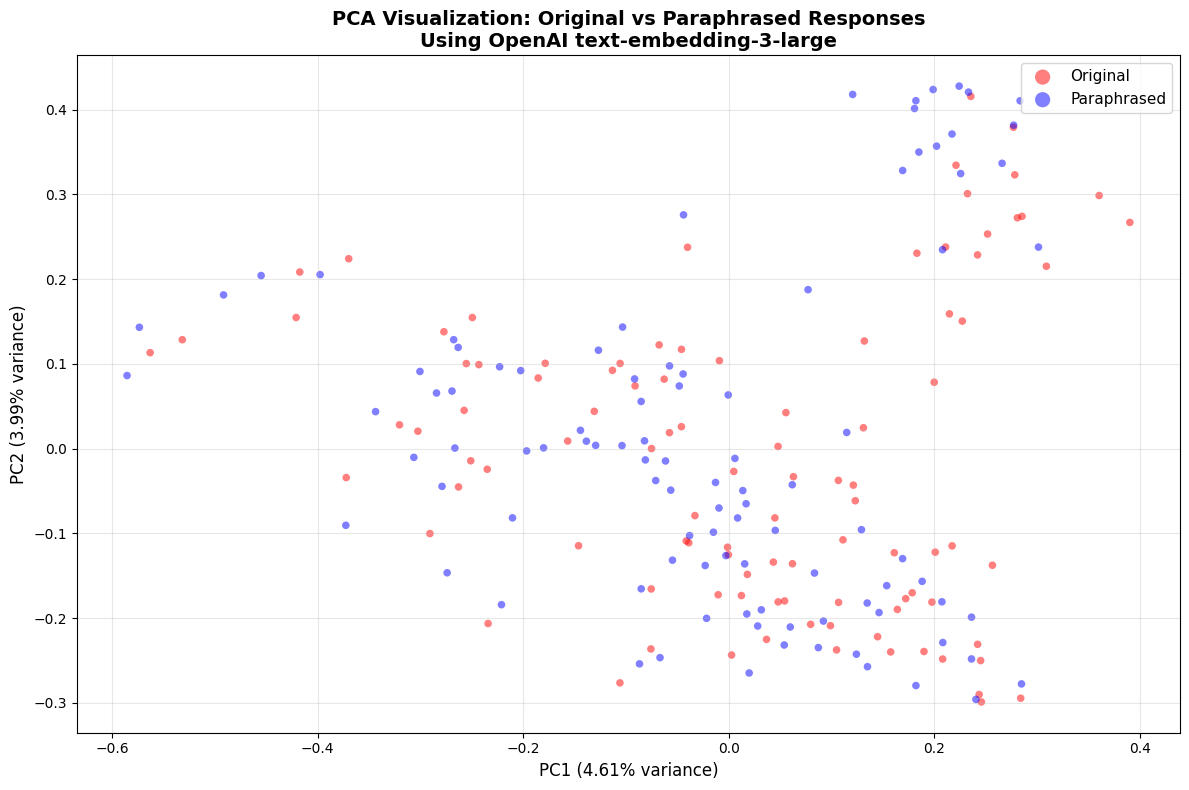

PCA plot saved as 'pca_original_vs_paraphrased.png'


In [37]:
plt.figure(figsize=(12, 8))

# Plot original responses in red
plt.scatter(original_2d[:, 0], original_2d[:, 1], 
           c='red', alpha=0.5, s=30, label='Original', edgecolors='none')

# Plot paraphrased responses in blue
plt.scatter(paraphrased_2d[:, 0], paraphrased_2d[:, 1], 
           c='blue', alpha=0.5, s=30, label='Paraphrased', edgecolors='none')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title('PCA Visualization: Original vs Paraphrased Responses\n' + 
         f'Using OpenAI {EMBEDDING_MODEL}', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, markerscale=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save plot
plt.savefig('pca_original_vs_paraphrased.png', dpi=300, bbox_inches='tight')
plt.show()

print("PCA plot saved as 'pca_original_vs_paraphrased.png'")


ValueError: 'c' argument has 20177 elements, which is inconsistent with 'x' and 'y' with size 100.

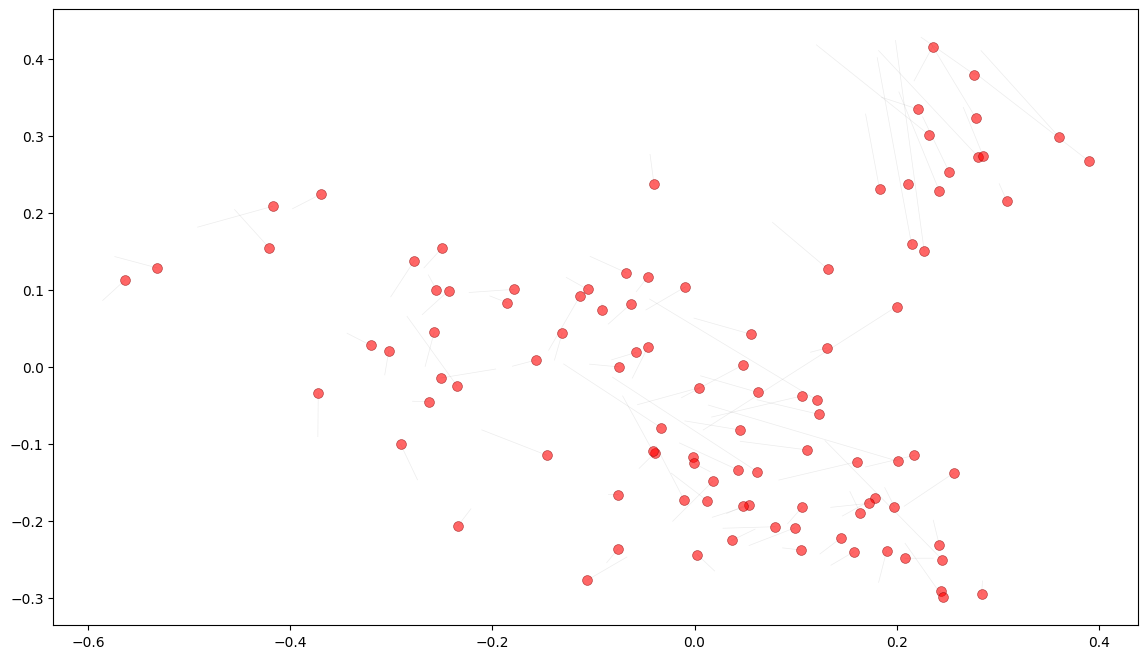

In [38]:
fig, ax = plt.subplots(figsize=(14, 8))

# Draw lines connecting original to paraphrased pairs
for i in range(len(original_2d)):
    ax.plot([original_2d[i, 0], paraphrased_2d[i, 0]], 
            [original_2d[i, 1], paraphrased_2d[i, 1]], 
            'gray', alpha=0.15, linewidth=0.5, zorder=1)

# Plot original responses in red
scatter_orig = ax.scatter(original_2d[:, 0], original_2d[:, 1], 
                         c='red', alpha=0.6, s=50, label='Original', 
                         edgecolors='darkred', linewidth=0.5, zorder=3)

# Plot paraphrased responses with color gradient based on divergent_tokens
# Use a colormap that transitions smoothly (Blues for blue gradient)
scatter_para = ax.scatter(paraphrased_2d[:, 0], paraphrased_2d[:, 1], 
                         c=divergent_tokens, cmap='Blues', alpha=0.7, s=50, 
                         edgecolors='darkblue', linewidth=0.5, zorder=2,
                         vmin=0, vmax=min(50, divergent_tokens.max()))

# Add colorbar for divergent_tokens on the right
cbar = plt.colorbar(scatter_para, ax=ax, pad=0.02)
cbar.set_label('Divergent Tokens', fontsize=12, rotation=270, labelpad=20)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
ax.set_title('PCA Visualization: Original vs Paraphrased Responses\n' + 
            f'Using OpenAI {EMBEDDING_MODEL}', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, markerscale=1.5, loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()

# Save plot
plt.savefig('pca_original_vs_paraphrased.png', dpi=300, bbox_inches='tight')
plt.show()

print("PCA plot saved as 'pca_original_vs_paraphrased.png'")


NameError: name 'divergent_tokens' is not defined

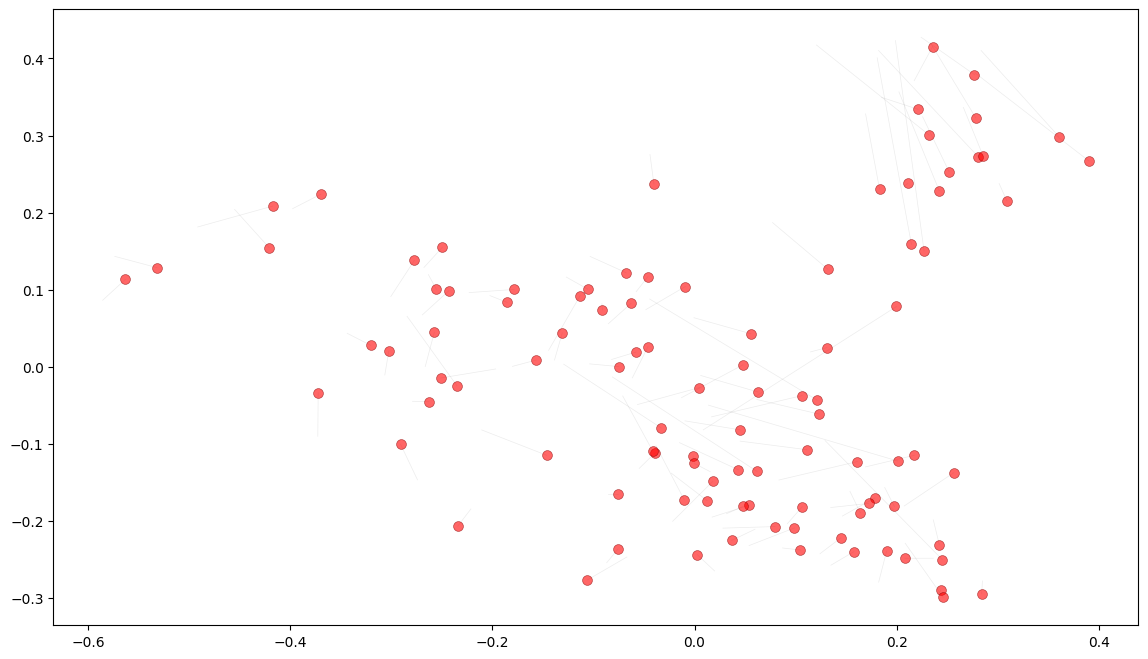

In [ ]:
# Plot with lines connecting original to paraphrased pairs
plt.figure(figsize=(12, 8))

# Draw lines connecting pairs (sample only first 100 to avoid clutter)
n_lines = min(100, len(original_2d))
for i in range(n_lines):
    plt.plot([original_2d[i, 0], paraphrased_2d[i, 0]], 
            [original_2d[i, 1], paraphrased_2d[i, 1]], 
            'gray', alpha=0.2, linewidth=0.5)

# Plot points
plt.scatter(original_2d[:, 0], original_2d[:, 1], 
           c='red', alpha=0.6, s=30, label='Original', edgecolors='darkred', linewidth=0.5)
plt.scatter(paraphrased_2d[:, 0], paraphrased_2d[:, 1], 
           c='blue', alpha=0.6, s=30, label='Paraphrased', edgecolors='darkblue', linewidth=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title(f'PCA with Pair Connections (first {n_lines} pairs)\n' + 
         f'Using OpenAI {EMBEDDING_MODEL}', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, markerscale=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save plot
plt.savefig('pca_with_connections.png', dpi=300, bbox_inches='tight')
plt.show()

print("PCA plot with connections saved as 'pca_with_connections.png'")


### Cosine Similarity Distribution


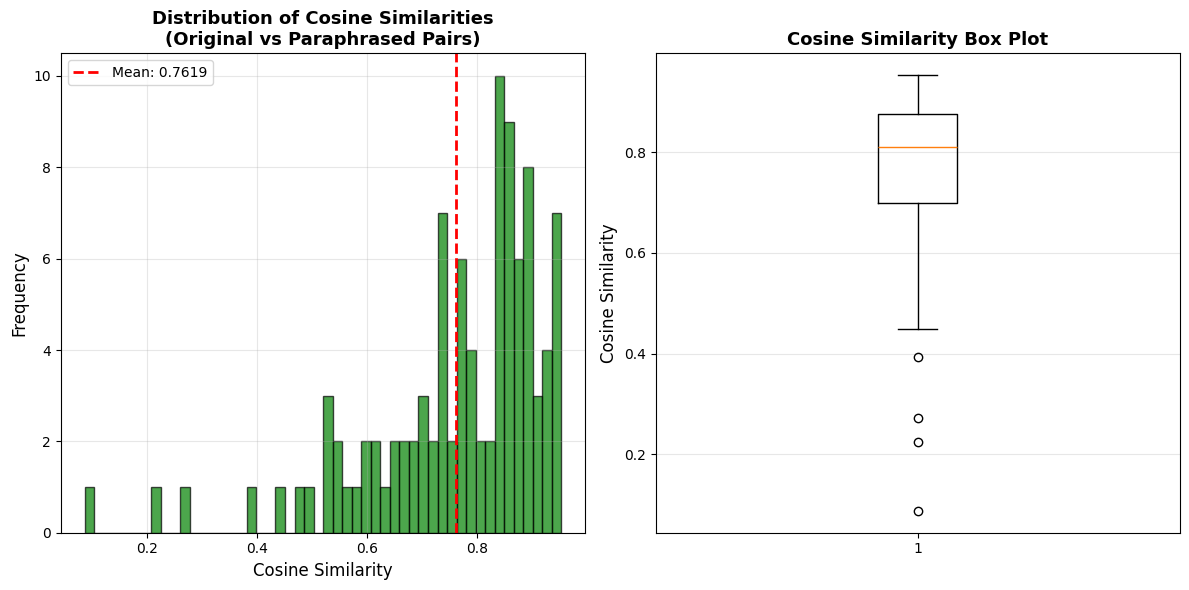

Cosine similarity plot saved as 'cosine_similarity_distribution.png'


In [ ]:
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(cosine_similarities, bins=50, color='green', alpha=0.7, edgecolor='black')
plt.axvline(cosine_similarities.mean(), color='red', linestyle='--', 
           linewidth=2, label=f'Mean: {cosine_similarities.mean():.4f}')
plt.xlabel('Cosine Similarity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Cosine Similarities\n(Original vs Paraphrased Pairs)', 
         fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Box plot
plt.subplot(1, 2, 2)
plt.boxplot(cosine_similarities, vert=True)
plt.ylabel('Cosine Similarity', fontsize=12)
plt.title('Cosine Similarity Box Plot', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

# Save plot
plt.savefig('cosine_similarity_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Cosine similarity plot saved as 'cosine_similarity_distribution.png'")


## Statistics Summary


In [ ]:
print("=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
print(f"\nDataset: {DATASET_NAME}")
print(f"Embedding Model: {EMBEDDING_MODEL}")
print(f"Number of samples: {len(original_embeddings)}")
print(f"Embedding dimension: {original_embeddings.shape[1]}")
print(f"\nPCA:")
print(f"  - PC1 variance explained: {pca.explained_variance_ratio_[0]:.4f}")
print(f"  - PC2 variance explained: {pca.explained_variance_ratio_[1]:.4f}")
print(f"  - Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")
print(f"\nCosine Similarity (Original vs Paraphrased):")
print(f"  - Mean: {cosine_similarities.mean():.4f}")
print(f"  - Std: {cosine_similarities.std():.4f}")
print(f"  - Min: {cosine_similarities.min():.4f}")
print(f"  - Max: {cosine_similarities.max():.4f}")
print(f"  - Median: {np.median(cosine_similarities):.4f}")
print(f"  - 25th percentile: {np.percentile(cosine_similarities, 25):.4f}")
print(f"  - 75th percentile: {np.percentile(cosine_similarities, 75):.4f}")
print("\n" + "=" * 60)


SUMMARY STATISTICS

Dataset: Taywon/alpaca_Llama-3.1-8B-Instruct_tiger_greedy_divergence
Embedding Model: text-embedding-3-large
Number of samples: 100
Embedding dimension: 3072

PCA:
  - PC1 variance explained: 0.0461
  - PC2 variance explained: 0.0399
  - Total variance explained: 0.0860

Cosine Similarity (Original vs Paraphrased):
  - Mean: 0.7619
  - Std: 0.1638
  - Min: 0.0869
  - Max: 0.9541
  - Median: 0.8105
  - 25th percentile: 0.6986
  - 75th percentile: 0.8759



## Find Most and Least Similar Pairs


In [ ]:
# Find indices of most and least similar pairs
most_similar_idx = np.argmax(cosine_similarities)
least_similar_idx = np.argmin(cosine_similarities)

print("Most Similar Pair:")
print(f"Cosine Similarity: {cosine_similarities[most_similar_idx]:.4f}")
print(f"\nOriginal: {original_responses[most_similar_idx]}")
print(f"\nParaphrased: {paraphrased_responses[most_similar_idx]}")
print("\n" + "="*80 + "\n")

print("Least Similar Pair:")
print(f"Cosine Similarity: {cosine_similarities[least_similar_idx]:.4f}")
print(f"\nOriginal: {original_responses[least_similar_idx]}")
print(f"\nParaphrased: {paraphrased_responses[least_similar_idx]}")


Most Similar Pair:
Cosine Similarity: 0.9541

Original: The Cuban Missile Crisis and the Vietnam War were two of the largest and deadliest conflicts of the 20th century. The Cuban Missile Crisis involved a standoff between the United States and the Soviet Union over Soviet nuclear missile bases in Cuba, while the Vietnam War was a prolonged military conflict in Indochina between the North, which was backed by the Soviet Union and the South, which was backed by the United States. The Cuban Missile Crisis unfolded over a period of 13 days in October 1962, with the resolution coming in the form of a diplomatic agreement. The Vietnam War lasted for 19 years, beginning in 1954 and ending in 1973, with the signing of the Paris Peace Accords. While both of these conflicts were Cold War related, they were also very different in terms of causes, objectives, strategic objectives and outcomes. The Cuban Missile Crisis did not result in any direct military conflict and was resolved primarily throu